In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/denis/BTCUSDT_2020.csv")

In [3]:
df_open = pd.DataFrame([df.dateTime, df.open]).T

In [4]:
df_open.describe()

,dateTime,open
count,147235,147235.00
unique,147235,142549.00
top,2020-01-01 00:00:00,29449.99
freq,1,7.00


In [5]:
df_open.head()

,dateTime,open
0,2020-01-01 00:00:00,7195.24
1,2020-01-01 00:15:00,7180.97
2,2020-01-01 00:30:00,7178.19
3,2020-01-01 00:45:00,7179.35
4,2020-01-01 01:00:00,7176.47


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [7]:
df_open.open = df_open.open.astype('float32')

In [8]:
df_open.drop(columns = ['dateTime'], inplace = True)

In [9]:
scaled = scaler.fit_transform(df_open)

In [10]:
df_scaled = pd.DataFrame(scaled)

In [11]:
df_scaled.head()

,0
0,0.047427
1,0.047223
2,0.047183
3,0.047199
4,0.047158


In [12]:
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[:train_size], df_scaled[train_size:]

In [13]:
device = 'cuda'

In [14]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback].values
        target = dataset.iloc[i+lookback].values[0]
        X.append(feature)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    return torch.Tensor(X), torch.Tensor(y)

In [15]:
lookback = 100
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([117688, 100, 1]) torch.Size([117688])
torch.Size([29347, 100, 1]) torch.Size([29347])


In [16]:
import torch.nn as nn
from torch.nn import functional

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [18]:
class BTCModel(nn.Module):
    def __init__(self, input_dim=1, d_model=256, nhead=4, num_layers=1, dropout=0.2):
        super(BTCModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
def MAPE(output, target):
  return torch.mean(torch.abs((target - output) / target))

In [36]:
from tqdm.auto import tqdm
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = BTCModel().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
MSE = nn.MSELoss()
MAE = nn.SmoothL1Loss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128)
eval_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle = False, batch_size = 128)

n_epochs = 46
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in tqdm(loader, desc=f'Training epoch {epoch}:'):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = MAE(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 5 != 0:
        continue
    model.eval()
    test_rmse = []
    test_mae = []
    test_mape = []
    with torch.no_grad():
        for X_batch, y_batch in eval_loader:
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)
          y_pred = model(X_batch)
          test_rmse.append(torch.sqrt(MSE(y_pred, y_batch)).item())
          test_mae.append(MAE(y_pred, y_batch).item())
          test_mape.append(MAPE(y_pred, y_batch).item())

    av_mae = sum(test_mae)/len(test_mae)
    av_rmse = sum(test_rmse)/len(test_rmse)
    av_mape = sum(test_mape)/len(test_mape)
    print("Epoch %d: test RMSE %.6f test MAE %.6f test MAPE %.6f" % (epoch, av_rmse, av_mae, av_mape))

Training epoch 0::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 0: test RMSE 0.110866 test MAE 0.013489 test MAPE 0.188189


Training epoch 1::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 5: test RMSE 0.115899 test MAE 0.015366 test MAPE 0.198336


Training epoch 6::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 10: test RMSE 0.117357 test MAE 0.015464 test MAPE 0.200026


Training epoch 11::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 15: test RMSE 0.082898 test MAE 0.007929 test MAPE 0.140529


Training epoch 16::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 20: test RMSE 0.049385 test MAE 0.002595 test MAPE 0.084657


Training epoch 21::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 25: test RMSE 0.031255 test MAE 0.001025 test MAPE 0.052834


Training epoch 26::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 30: test RMSE 0.022645 test MAE 0.000601 test MAPE 0.036474


Training epoch 31::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 35: test RMSE 0.017129 test MAE 0.000304 test MAPE 0.030730


Training epoch 36::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 40: test RMSE 0.016752 test MAE 0.000327 test MAPE 0.028821


Training epoch 41::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 45: test RMSE 0.014860 test MAE 0.000296 test MAPE 0.023754


In [37]:
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in tqdm(loader, desc=f'Training epoch {epoch}:'):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = MAE(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 5 != 0:
        continue
    model.eval()
    test_rmse = []
    test_mae = []
    test_mape = []
    with torch.no_grad():
        for X_batch, y_batch in eval_loader:
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)
          y_pred = model(X_batch)
          test_rmse.append(torch.sqrt(MSE(y_pred, y_batch)).item())
          test_mae.append(MAE(y_pred, y_batch).item())
          test_mape.append(MAPE(y_pred, y_batch).item())

    av_mae = sum(test_mae)/len(test_mae)
    av_rmse = sum(test_rmse)/len(test_rmse)
    av_mape = sum(test_mape)/len(test_mape)
    print("Epoch %d: test RMSE %.6f test MAE %.6f test MAPE %.6f" % (epoch, av_rmse, av_mae, av_mape))

Training epoch 0::   0%|          | 0/920 [00:00<?, ?it/s]

Epoch 0: test RMSE 0.014761 test MAE 0.000293 test MAPE 0.023030


Training epoch 1::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/920 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/920 [00:00<?, ?it/s]

In [45]:
preds = []
real = []
test_rmse = []
test_mae = []
test_mape = []
with torch.no_grad():
        for X_batch, y_batch in eval_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds += model(X_batch).flatten().tolist()
            y_pred = model(X_batch)
            real += y_batch.flatten().tolist()
            test_rmse.append(torch.sqrt(MSE(y_pred, y_batch)).item())
            test_mae.append(MAE(y_pred, y_batch).item())
            test_mape.append(MAPE(y_pred, y_batch).item())

av_mae = sum(test_mae)/len(test_mae)
av_rmse = sum(test_rmse)/len(test_rmse)
av_mape = sum(test_mape)/len(test_mape)
print("Epoch %d: test RMSE %.6f test MAE %.6f test MAPE %.6f" % (epoch, av_rmse, av_mae, av_mape))

Epoch 4: test RMSE 0.032349 test MAE 0.001066 test MAPE 0.053140


In [41]:
len(preds)

29347

In [42]:
len(real)

29347

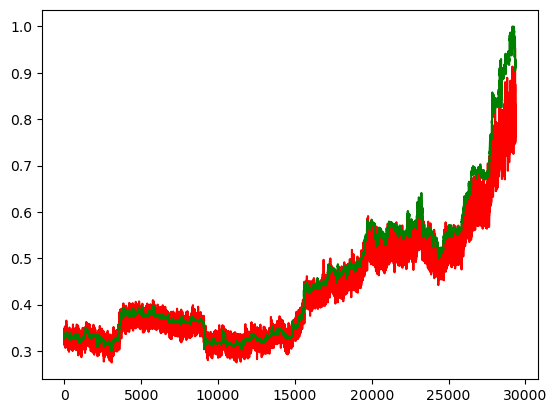

In [43]:
plt.plot(preds, c='r')
plt.plot(y_test, c='g')
plt.show()

In [46]:
torch.save(model.state_dict(), 'C:/Users/denis/TransformerBTC.pt')